# ***Mnist Hypothesis Project***
### This project investigates the impact of regularization techniques, model capacity,</br> activation funtions on image classification performance using the MNIST dataset.
### Furthermore, we compare Linear Models to Multi-Layer-Perceptrons to analyze how architectural complexity and hyperparameters shifts impact classification accuracy.
#####

# ***Data preparation***

### Importing Python Libraries

In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import random_split

import matplotlib.pyplot as plt
from IPython.display import clear_output

from statistics import mean
import random
import time

### Loading the Mnist Dataset

In [2]:
def dataset_load(root="../mnist_project/data"):    
    train_data = torchvision.datasets.MNIST(root=root, train=True, transform=transforms.ToTensor(), download=False)
    test_tens = torchvision.datasets.MNIST(root=root, train=False, transform=transforms.ToTensor(), download=False)
    
    train_tens, val_tens = random_split(train_data, [50000, 10000], generator=torch.Generator().manual_seed(42))
    return train_tens, val_tens, test_tens

In [3]:
train_tensor, val_tensor, test_tensor = dataset_load()

In [4]:
len(train_tensor), len(val_tensor), len(test_tensor)

(50000, 10000, 10000)

### Inspecting training tensor ***(28x28 grayscale)***

In [5]:
train_tensor[0][0].shape, train_tensor[0][1]

(torch.Size([1, 28, 28]), 6)

### Iterating and Visualizing the dataset

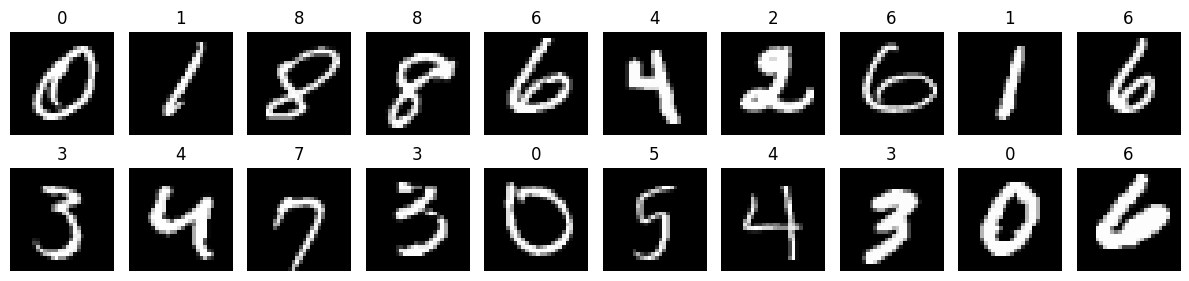

In [6]:
rand_idx = random.sample(range(0, len(train_tensor)), 20)

figure = plt.figure(figsize=(12, 3), tight_layout=True)

for i in range(len(rand_idx)):
    img, label = train_tensor[rand_idx[i]]
    figure.add_subplot(2, 10, i+1)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

###
## ***Data loaders***

In [7]:
def data_loader(data, is_train, batch_size):
    return torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=is_train, num_workers=1)

In [62]:
def test_loader(data, batch_size):
    return torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=1)

####
#### It takes around 3/4 seconds to iterate through whole test set - ***50 thousands examples***.

In [9]:
tic = time.time()
for X, y in data_loader(train_tensor, True, 256):
    continue
f'{time.time() - tic:.2f} sec'

'4.15 sec'

####
#### Feature tensor ***X_1*** contains given amount of 28x28 images with ***one*** gray-scale channel. 
#### Label tensor ***y_1*** (1D Tensor) contains categorical labels, where each element is an integer in the range ***0-9***.

In [10]:
X_1, y_1 = next(iter(data_loader(train_tensor, True, 64))) 
print("Shapes:", X_1.shape, X_1.dtype, y_1.shape, y_1.dtype, '\n')
print(y_1, '\n')
print(X_1.min(), X_1.max()) # 0 - black | 1 - white

Shapes: torch.Size([64, 1, 28, 28]) torch.float32 torch.Size([64]) torch.int64 

tensor([3, 9, 9, 7, 2, 7, 7, 9, 7, 4, 6, 7, 2, 7, 6, 5, 8, 2, 5, 4, 8, 6, 5, 1,
        9, 9, 1, 6, 4, 9, 0, 7, 3, 2, 0, 8, 0, 4, 5, 4, 7, 8, 7, 2, 4, 6, 7, 9,
        0, 8, 7, 6, 1, 2, 8, 9, 2, 6, 4, 4, 6, 5, 4, 9]) 

tensor(0.) tensor(1.)


#####
### ***Visualizing batch elements to verify label-image alignment***

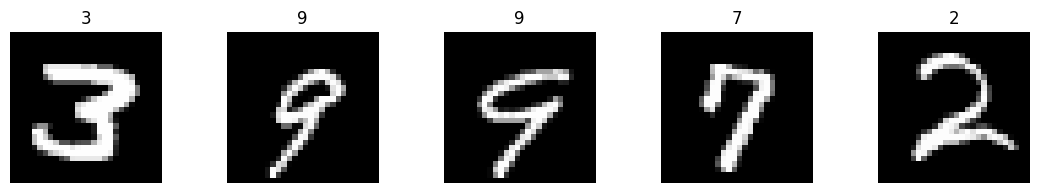

In [11]:
rand_idx = random.sample(range(0, 64), 5)
figure = plt.figure(figsize=(11, 2), tight_layout=True)
for i in range(len(rand_idx)):
    img, label = X_1[i], y_1[i]
    figure.add_subplot(1, 5, i+1)
    plt.title(label.item())
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# ***Core Classes***
### This section defines the main classes used by all models in this project.

###
## ***Plotter Class***
#### Simple class using ***MatPlotLib*** library used for visualizing train/val loss and accuracy.

In [17]:
class Plotter():
    def __init__(self, title):
        self.title = title

    def plot(self, train_losses, val_losses, accuracy):
        clear_output(wait=True) 
        epochs = range(1, len(train_losses) + 1)
        plt.figure(figsize=(8,5))
        plt.plot(epochs, train_losses, label=f"Train loss: {train_losses[-1]:.4f}")
        plt.plot(epochs, val_losses, label=f"Val loss: {val_losses[-1]:.4f}")
        plt.plot(epochs, accuracy, linestyle="-.", label=f"Val acc: {accuracy[-1]:.4f}")
        plt.xlabel("Epoch")
        plt.title(self.title)
        plt.legend()
        plt.show()

###
## ***Trainer Class***
#### A lightweight training utility implemented to standardize the training loop across experiments.

In [14]:
class Trainer():
    def __init__(self, num_epochs):
        self.num_epochs = num_epochs

    def prepare_data(self, train_data, val_data):
        self.train_dataloader = data_loader(train_data, True, 256)
        self.val_dataloader = data_loader(val_data, False, 256)     

        
    def fit(self, model, train_data, val_data, plotter):
        self.prepare_data(train_data, val_data)
        model.trainer = self
        self.model = model
        self.optim = model.config_optim()
        
        self.plotter = plotter
        self.train_losses_epoch = []
        self.val_losses_epoch = []
        self.val_accuracy_epoch = []
        
        for _ in range(self.num_epochs):
            self.fit_epoch()
            self.plotter.plot(self.train_losses_epoch, self.val_losses_epoch, self.val_accuracy_epoch)

    def fit_epoch(self):
        train_losses_batch = []
        val_losses_batch = []
        val_accuracy = []
        
        self.model.train()
        for batch in self.train_dataloader:
            loss, _ = self.model.batch_step(batch)
            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
            train_losses_batch.append(loss.item())
            
        self.model.eval()
        for batch in self.val_dataloader:
            with torch.no_grad():
                l, acc = self.model.batch_step(batch)
                val_losses_batch.append(l.item())
                val_accuracy.append(acc.item())
                
        self.train_losses_epoch.append(mean(train_losses_batch))
        self.val_losses_epoch.append(mean(val_losses_batch))  
        self.val_accuracy_epoch.append(mean(val_accuracy))

####
# ***Base Linear Model***
#### In this section, we create simple linear baseline model to compare with later models.

## ***Model Class***
#### Simple linear model with ***Stochastic Gradient Descent*** optimizer and ***Cross-Entropy Loss***.

In [15]:
class BaseModel(nn.Module):
    def __init__(self, lr, num_outputs):
        super().__init__()
        self.lr = lr
        self.num_outputs = num_outputs
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(self.num_outputs))

    def forward(self, X):
        return self.net(X)

    def ce_loss(self, Y_hat, Y):
        return F.cross_entropy(Y_hat, Y, reduction='mean')

    def config_optim(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)

    def batch_step(self, batch):
        Y_hat = self.forward(batch[0])
        l = self.ce_loss(Y_hat, batch[1])
        acc = (Y_hat.argmax(dim=1) == batch[1]).float().mean()
        return l, acc

###
## ***Training***

### - Learning rate `0.01`
#####

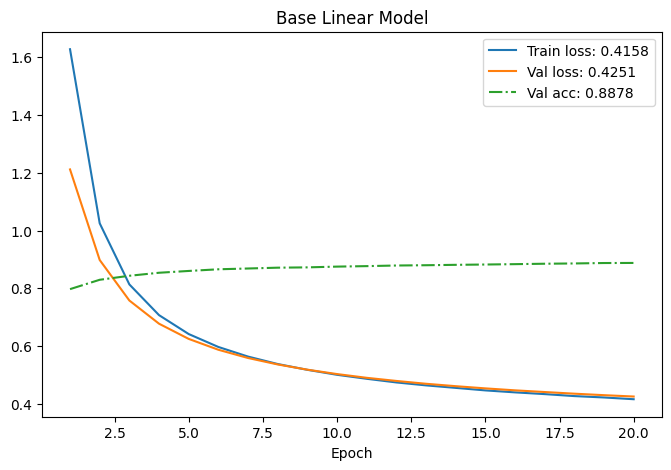

In [18]:
base_model = BaseModel(0.01, 10)
plotter = Plotter("Base Linear Model")
base_trainer = Trainer(20)
base_trainer.fit(base_model, train_tensor, val_tensor, plotter)

### - Learning rate `0.05`
#####

#### It can be clearly seen that higher learning rate achieves substantially lower train/val loss and higher accuracy meaning </br>that previous value ***0.01*** was too low for ***20 epochs***.

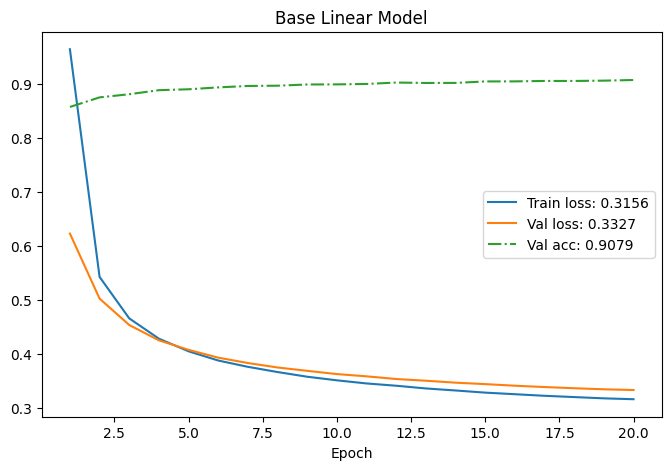

In [19]:
base_model = BaseModel(0.05, 10)
base_trainer.fit(base_model, train_tensor, val_tensor, plotter)

### - Learning rate `0.1`
#####

#### Suprisingly, increasing learning rate to ***0.1*** did not yield any significant improvements.
#### This suggests that number of epochs is too small or ***model may have reached peak in its limited capacity***. 

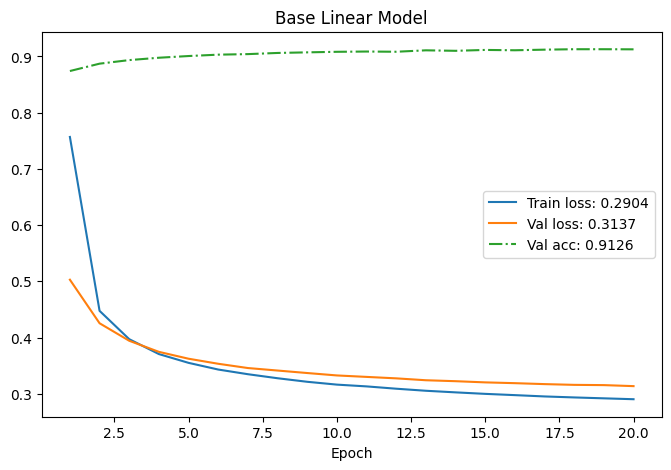

In [61]:
base_linear_model = BaseModel(0.1, 10)
base_linear_trainer = Trainer(20)
plotter = Plotter("Base Linear Model")
base_linear_trainer.fit(base_linear_model, train_tensor, val_tensor, plotter)

####
### Visualizing Falsely predicted Numbers

In [59]:
def plot_false_predic(zipped):
    figure = plt.figure(figsize=(12, 3), tight_layout=True)
    for i, (img, f_label) in enumerate(zipped):
        figure.add_subplot(2, 10, i+1)
        plt.title(f_label.item())
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

In [60]:
def false_predic(data_loader, model):
    images, labels = data_loader
    
    with torch.no_grad():
        predic_labels = torch.argmax(F.softmax(model.forward(images), dim=1), dim=1)
    mask = (predic_labels != labels)
    
    diff_imgs = images[mask]
    diff_lbs = predic_labels[mask]
    print(f"False labels in batch: {diff_imgs.size(0)}\n")
    sample_num = min(20, diff_imgs.size(0))
    indices = torch.randperm(diff_imgs.size(0))[:sample_num]
    
    plot_false_predic(zip(diff_imgs[indices], diff_lbs[indices]))

#####
### ***Conclusion:***
#### It is clear that model makes mistakes when classifying certain types of numbers i.e. Model confuses digits with rounded segments or just badly written examples.
#### This suggests that treating images as flat vectors i.e. Vectorizing spatial data limits model's ability to distinguish between digits with similar shapes.

False labels in batch: 24



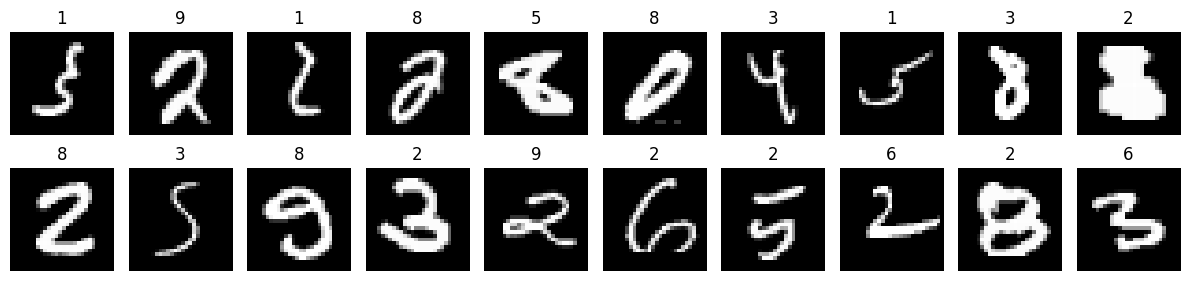

In [67]:
false_predic(next(iter(base_linear_trainer.val_dataloader)), base_linear_model)

# ***Base MLP Model***
#### While the linear model achieved "reasonable" performance, it had very ***narrow capacity***, limiting its ability to learn more complex patterns.
#### To further our analysis, we implement ***Multi-Layer-Perceptron***. Although we still treat images as flat vectors, adding hidden neurons enables the model to learn ***non-linear patterns***.
#####

## ***MLP One Hidden Layer Class***
#### Simple MLP model with ***Stochastic Gradient Descent*** optimizer, ***Cross-Entropy Loss***.
#### Additionally, the class also provides key functionality for further analysis i.e. Dropout and activation functions.

In [26]:
class BaseMLP(nn.Module):
    def __init__(self, num_outputs, num_hiddens, dropout_num, act_name, lr):
        super().__init__()
        self.num_outputs = num_outputs
        self.num_hiddens = num_hiddens
        self.act_name = act_name
        self.lr = lr
        if self.act_name == 'ReLU':
            self.act_func = nn.ReLU()
        else:
            self.act_func = nn.Tanh()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(self.num_hiddens), self.act_func,
                                 nn.Dropout(dropout_num), nn.LazyLinear(self.num_outputs))
        
    def forward(self, X):
        return self.net(X)

    def ce_loss(self, Y_hat, Y):
        return F.cross_entropy(Y_hat, Y, reduction='mean')

    def config_optim(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)

    def batch_step(self, batch):
        Y_hat = self.forward(batch[0])
        l = self.ce_loss(Y_hat, batch[1])
        acc = (Y_hat.argmax(dim=1) == batch[1]).float().mean()
        return l, acc

## ***Training***
#### 

### ***Model 1*** - Base MLP ***(ReLU activation function)***

#### It can be seen that even simple MLP model with one hidden layer, achieves substantially lower train/val loss and higher accuracy.
#### After just ***5 epochs***, the base mlp outperformed the linear model ***(trained with 20 epochs)***.
#### Upon closer inspection we can observe increasing difference between train and val loss **i.e. generalization gap**, meaning </br> that model may be beginning to fit more closely to train set, which after more extensive training might cause overfitting.

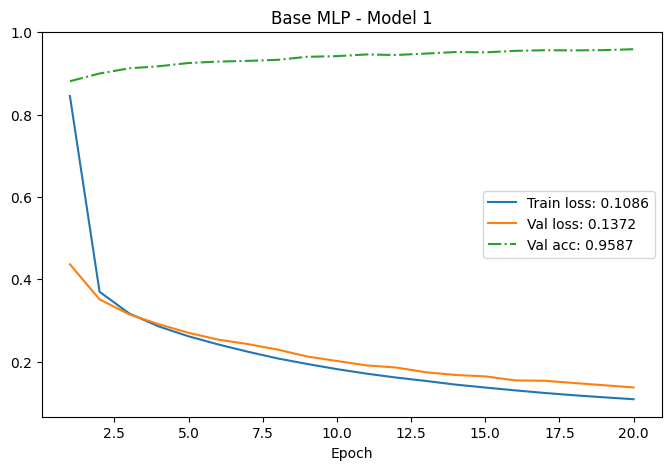

In [27]:
base_mlp = BaseMLP(num_outputs=10, num_hiddens=256, dropout_num=0, act_name='ReLU', lr=0.1)
plotter = Plotter("Base MLP - Model 1")
trainer = Trainer(20)
trainer.fit(base_mlp, train_tensor, val_tensor, plotter)

### ***Model 2*** - Base MLP lower learning rate
#### Before moving on to Generalization, lets see how model will react to lower learning rate and compare it to base linear model.
#####

#### Despite ***decreasing learning rate***, simple MLP still achieves substantially lower train and val loss compared to base linear model.
#### This proves that adding hidden neurons enabled the model to learn ***non-linear patterns*** and thus perform significantly better.

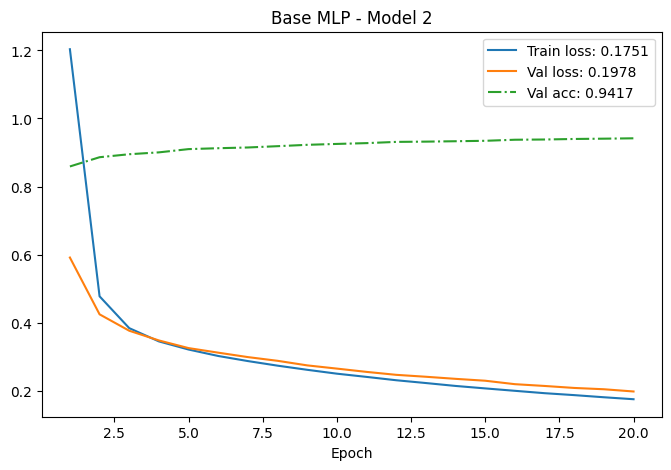

In [28]:
base_mlp = BaseMLP(num_outputs=10, num_hiddens=256, dropout_num=0, act_name='ReLU', lr=0.05)
plotter = Plotter("Base MLP - Model 2")
trainer.fit(base_mlp, train_tensor, val_tensor, plotter)

# ***Generalization***
###

## ***Investigation***

### ***Model 3*** - Base MLP `40 epochs`
#### ***To further investigate behavior described in Model 1, we will train model with higher number of epochs.***

#####
#### Despite increasing number of epochs, generalization gap has changed slighly, suggesting that the model capacity </br>is still well matched to the dataset. 

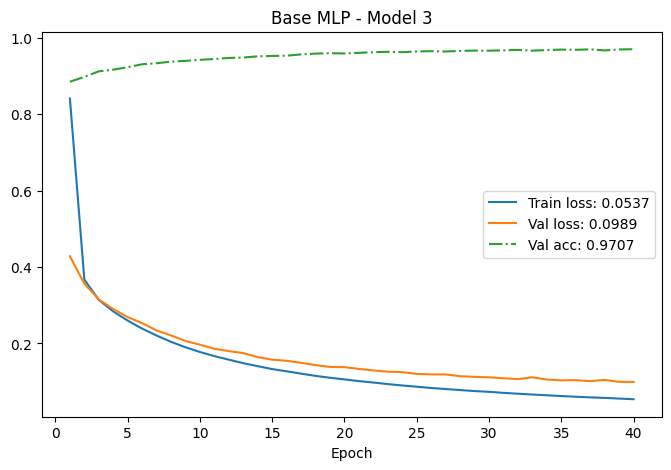

In [29]:
base_mlp = BaseMLP(num_outputs=10, num_hiddens=256, dropout_num=0, act_name='ReLU', lr=0.1)
plotter = Plotter("Base MLP - Model 3")
trainer = Trainer(40)
trainer.fit(base_mlp, train_tensor, val_tensor, plotter)

### ***Model 4*** - Base MLP `lr = 0.2`
#### ***Let's see how increasing learning rate value to 0.2 will affect model's performance and generalization gap.***

#####
#### Increased learning rate affected model's learning speed and made differences in losses much more visible.
#### Even though generalization gap is relatively low ***(~0.06)***, it is clear that model starts to fit more closely to train set.

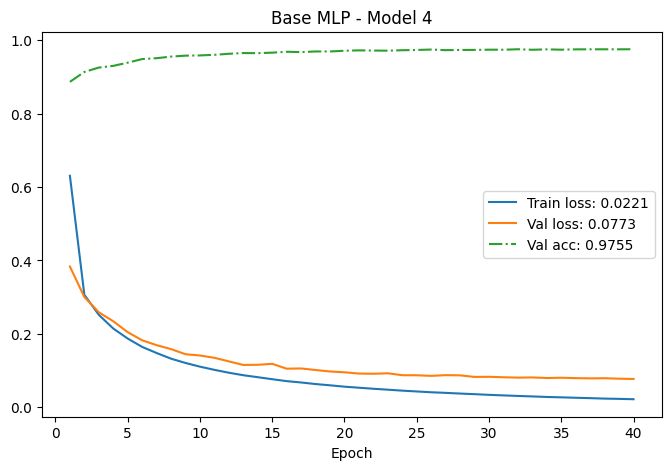

In [31]:
base_mlp = BaseMLP(num_outputs=10, num_hiddens=256, dropout_num=0, act_name='ReLU', lr=0.2)
plotter = Plotter("Base MLP - Model 4")
trainer = Trainer(40)
trainer.fit(base_mlp, train_tensor, val_tensor, plotter)

### ***Model 5*** - Base MLP `1024 hidden neurons`
#### ***Let's significantly increase number of hidden neurons to expand model's capacity.***

#####
#### Suprisingly, training and validation loss changed just slighly, suggesting that adding extra neurons to hidden</br> neurons provided minimal benefit.

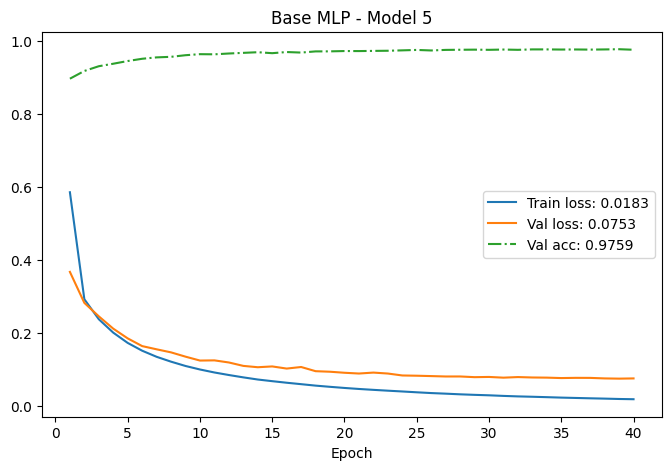

In [32]:
base_mlp = BaseMLP(num_outputs=10, num_hiddens=1024, dropout_num=0, act_name='ReLU', lr=0.2)
plotter = Plotter("Base MLP - Model 5")
trainer.fit(base_mlp, train_tensor, val_tensor, plotter)

### ***Model 6*** - Base MLP `lr = 0.3`
#### ***In order to push generalization gap to the limits, we can increase learning rate to 0.3***

#####
#### Increasing learning rate significantly **reduced** training loss, while validation loss ***stagnated***.
#### It can be clearly seen when comparing models 5 and 6: while their validation losses remains are ***similar***,</br> model 6 shows ***lower*** training loss, proving that further training provides ***minimal*** benefit.
#### This suggests the model is beginning to memorize training patterns that ***do not generalize***.

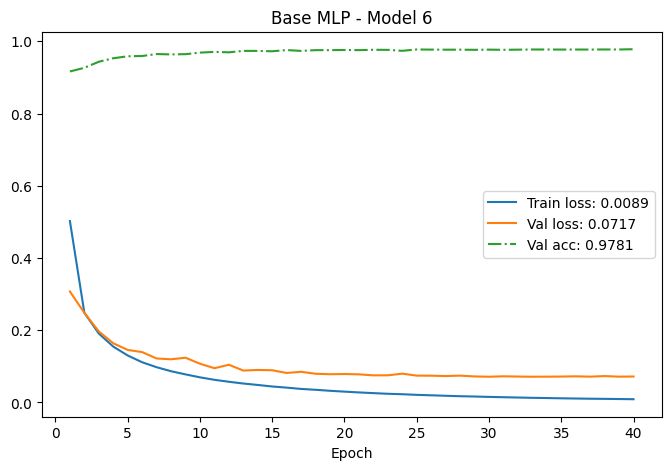

In [74]:
mlp_model_1 = BaseMLP(num_outputs=10, num_hiddens=1024, dropout_num=0, act_name='ReLU', lr=0.3)
plotter = Plotter("Base MLP - Model 6")
trainer_mlp1 = Trainer(40)
trainer_mlp1.fit(mlp_model_1, train_tensor, val_tensor, plotter)

## ***Implementing Dropout Generalization***
#### In order to help our model ***generalize better***, thus improve it's performance on validation data, we implement ***dropout***.
####

### ***Model 7*** - MLP `Dropout - 50%`
#### We set ***dropout_num*** variable to 0.5, meaning that in each iteration we will remove half of our hidden neurons.

#####
#### Applying Dropout reduced validation loss but increased training loss.
#### Comparing to the Model 6, we can also observe a slight increase of Val Accuracy, confirming that Dropout improved generalization.

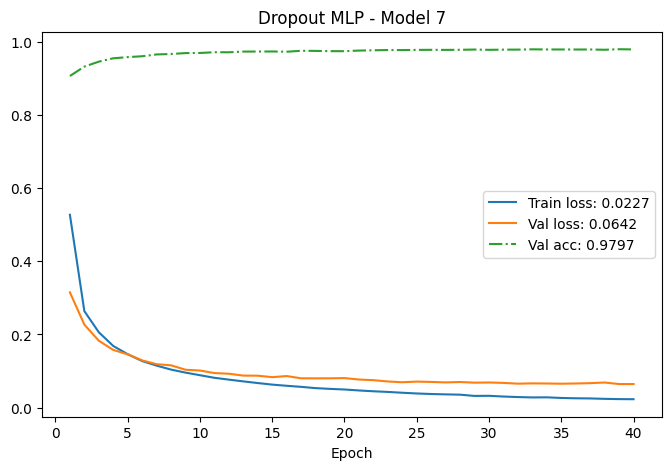

In [34]:
base_mlp = BaseMLP(num_outputs=10, num_hiddens=1024, dropout_num=0.5, act_name='ReLU', lr=0.3)
plotter = Plotter("Dropout MLP - Model 7")
trainer = Trainer(40)
trainer.fit(base_mlp, train_tensor, val_tensor, plotter)

### ***Model 8*** - Dropout MLP `256 hidden neurons`

#####
#### After decresing number of hidden neurons to 256, we can observe significant narrowing of the generalization gap.
#### Even though the accuracy has decreased, we can say that our model is more stable 

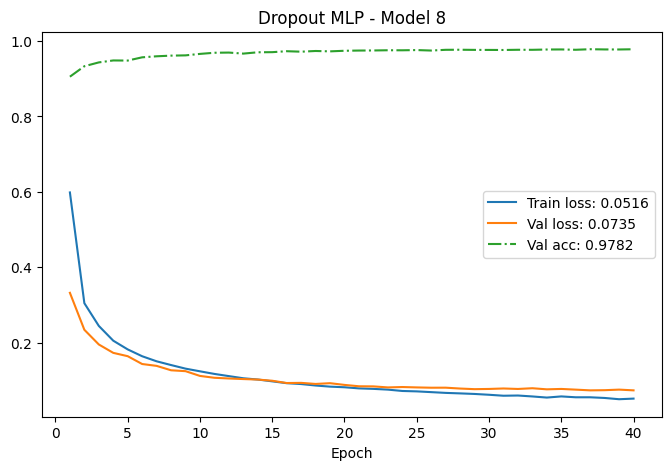

In [35]:
base_mlp = BaseMLP(num_outputs=10, num_hiddens=256, dropout_num=0.5, act_name='ReLU', lr=0.3)
plotter = Plotter("Dropout MLP - Model 8")
trainer = Trainer(40)
trainer.fit(base_mlp, train_tensor, val_tensor, plotter)

### ***Model 9*** - MLP `Dropout - 40%`
#### ***Let's test how reducing Dropout to 40% will affect performance of the model.***

#####
#### It is clear that the training loss as well as the generalization gap increased.
#### It proves that lowering Dropout rate impairs the model's ability to generalize.

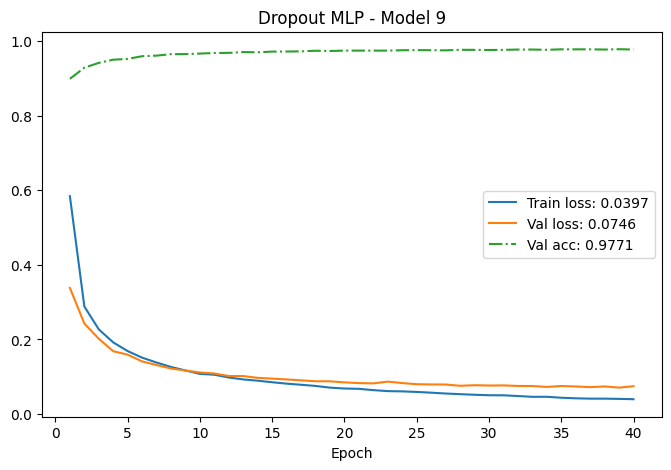

In [36]:
base_mlp = BaseMLP(num_outputs=10, num_hiddens=256, dropout_num=0.4, act_name='ReLU', lr=0.3)
plotter = Plotter("Dropout MLP - Model 9")
trainer = Trainer(40)
trainer.fit(base_mlp, train_tensor, val_tensor, plotter)

### ***Model 10*** - Dropout MLP `learning rate 0.1`
#### ***We set the dropout rate to 0.5 again, and decrease learning rate.***

#####
#### Although decreased learning rate resulted in increase of both train and val loss, difference between them got minimal, </br>suggesting that model got much more stable.

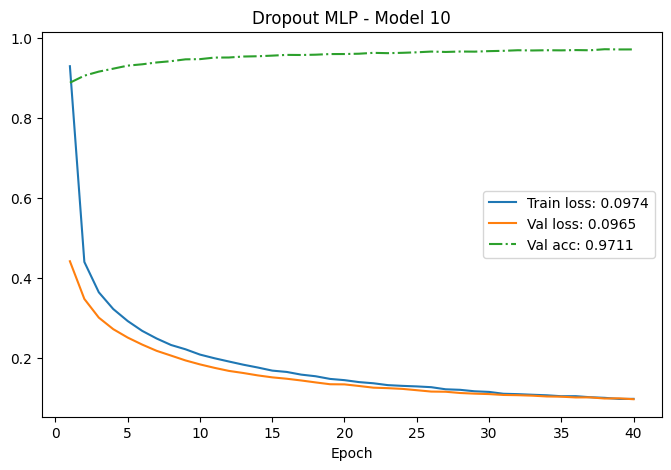

In [37]:
base_mlp = BaseMLP(num_outputs=10, num_hiddens=256, dropout_num=0.5, act_name='ReLU', lr=0.1)
plotter = Plotter("Dropout MLP - Model 10")
trainer = Trainer(40)
trainer.fit(base_mlp, train_tensor, val_tensor, plotter)

### ***Model 11*** - Dropout MLP `80 epochs`
#### ***To fully evaluate our MLP Model, we increase the number of epochs to allow its paramters to converge.***

####
#### While it may look like Model 9 achieved slightly higher accuracy with lower number of epochs, Model 11 shows</br> a substanially smaller generalization gap.
#### This indicates that a more gradual training process led to better stability, and generalization.

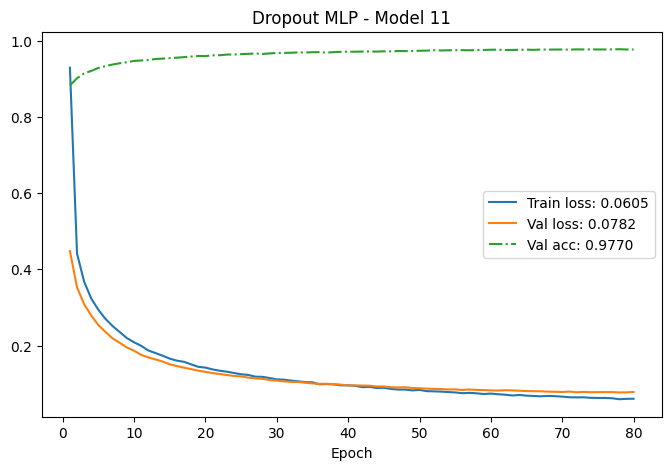

In [71]:
mlp_model_2 = BaseMLP(num_outputs=10, num_hiddens=256, dropout_num=0.5, act_name='ReLU', lr=0.1)
plotter = Plotter("Dropout MLP - Model 11")
trainer_mlp2 = Trainer(80)
trainer_mlp2.fit(mlp_model_2, train_tensor, val_tensor, plotter)

# ***Activation Function***
#### Since activation functions introduce non-linearity, they may significantly affect optimization dynamics and model performance.
#### In this section we will quickly analyze and compare ***Tanh*** and ***ReLU*** activation functions
###

### ***Model 12*** - Tanh MLP 

#### It is clear that training with Tanh appears ***smoother***, with fewer ***sudden*** loss changes.
#### Due to ***slower*** convergence speed, Tanh was unable to match ReLU's high performance. It may be explained</br> by vanishing gradient effect for ***larger*** input values.
#### Upon closer inspection we can also observe slight **instability*** in Tanh validation loss, suggesting that slower convergence </br> led to higher ***sensitivity*** to small variations.

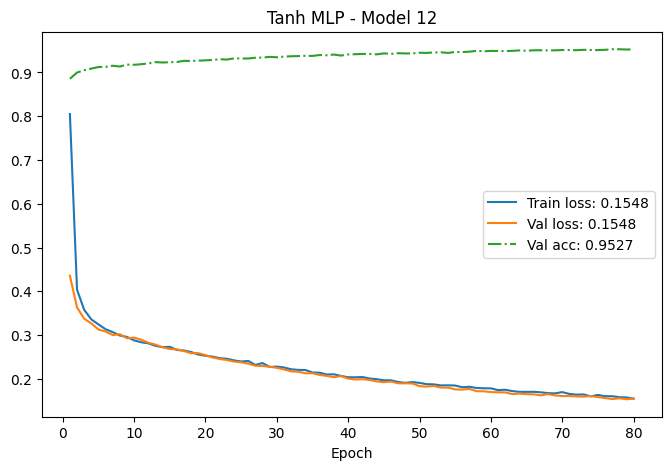

In [41]:
base_mlp = BaseMLP(num_outputs=10, num_hiddens=256, dropout_num=0.5, act_name='Tanh', lr=0.1)
plotter = Plotter("Tanh MLP - Model 12")
trainer_2 = Trainer(80)
trainer_2.fit(base_mlp, train_tensor, val_tensor, plotter)

### Comparing Tanh and ReLU's convergence speed

In [47]:
def compare_models(train1, val1, train2, val2, name_1, name_2, title):
    plt.figure(figsize=(8,5))
    epochs = range(1, len(train1) + 1)
    plt.plot(epochs, train1, label=f"{name_1} Train loss: {train1[-1]:.4f}")
    plt.plot(epochs, val1, linestyle="-.", label=f"{name_1} Val loss: {val1[-1]:.4f}")
    plt.plot(epochs, train2, label=f"{name_2} Train loss: {train2[-1]:.4f}")
    plt.plot(epochs, val2, linestyle="-.", label=f"{name_2} Val loss: {val2[-1]:.4f}")
    plt.xlabel("Epoch")
    plt.title(title)
    plt.legend()
    plt.show()

#### ***Conclusion:***
#### We can clearly observe that ReLU provides significantly faster convergence compared to Tanh.
#### Upon further inspection we can see difference in sensitivity to small variations; Tanh vall loss plotline is less stable</br>with many bumps throughout the whole training process.

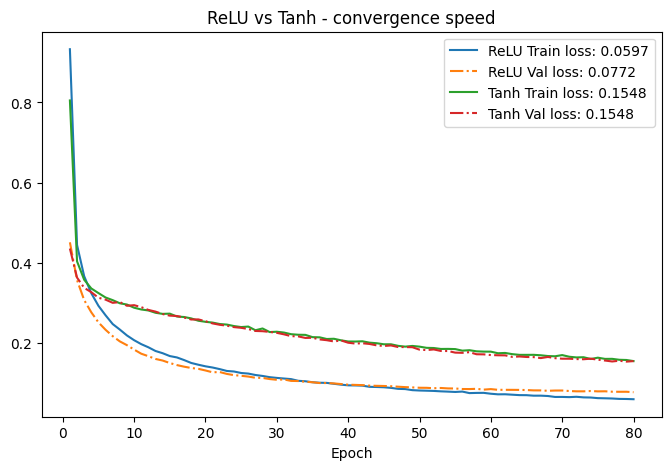

In [48]:
train_tanh, val_tanh = trainer_2.train_losses_epoch, trainer_2.val_losses_epoch
train_relu, val_relu = trainer_1.train_losses_epoch, trainer_1.val_losses_epoch
compare_models(train_relu, val_relu, train_tanh, val_tanh, "ReLU", "Tanh", "ReLU vs Tanh - convergence speed")

# ***Capacity***
#### In this section we will examine how number of hidden neurons affectes convergence and model's final performance. 
#### Since we already have trained with 256 and 1024 hidden neurons, we will compare model's with num_hiddens set to 128 and 512.

### ***Model 13*** - MLP `num_hiddens = 128`

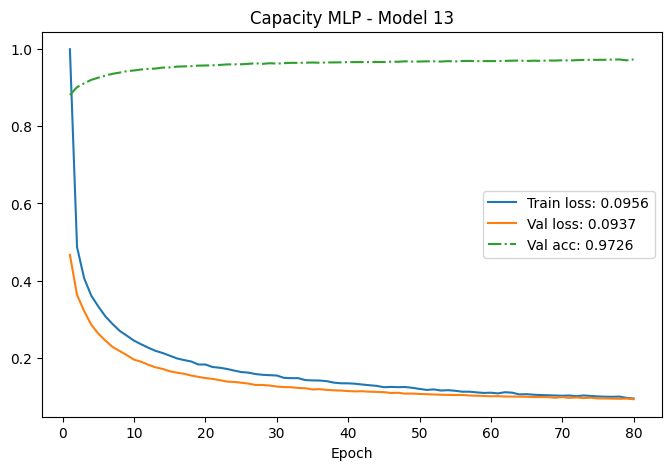

'Model 13 training time: 480.89 sec'

In [50]:
tic = time.time()
base_mlp = BaseMLP(num_outputs=10, num_hiddens=128, dropout_num=0.5, act_name='ReLU', lr=0.1)
plotter = Plotter("Capacity MLP - Model 13")
trainer_128 = Trainer(80)
trainer_128.fit(base_mlp, train_tensor, val_tensor, plotter)
f'Model 13 training time: {time.time() - tic:.2f} sec'

### ***Model 14*** - MLP `num_hiddens = 512`

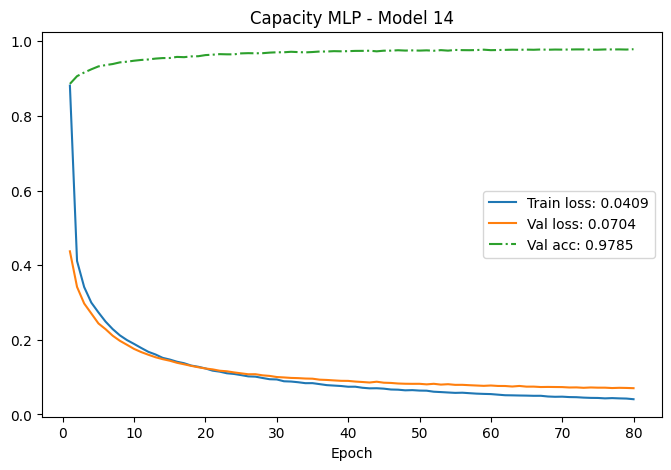

'Model 14 training time: 497.85 sec'

In [52]:
tic = time.time()
base_mlp = BaseMLP(num_outputs=10, num_hiddens=512, dropout_num=0.5, act_name='ReLU', lr=0.1)
plotter = Plotter("Capacity MLP - Model 14")
trainer_512 = Trainer(80)
trainer_512.fit(base_mlp, train_tensor, val_tensor, plotter)
f'Model 14 training time: {time.time() - tic:.2f} sec'

### Comparing Models

#### Although model with 512 hidden neurons achieves lower train/val loss, we can observe that it has higher generalization gap, </br>suggesting that adding extra neurons makes the model more likely to learn test set noise.
#### Upon closer inspection we can examine that the model with 512 hidden layer neurons has faster convergence, however</br> the one with smaller capacity maintained much more stable validation loss.
#### After analyzing the chart, we may arrive to the conlcusion that the most optimal value might be 256, because it guarantees</br> enough capacity, without needing to worry about model fitting more closely on the test set.

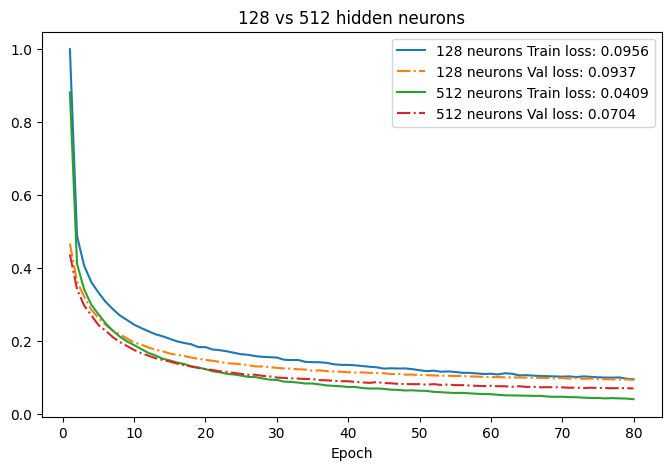

In [53]:
train_128, val_128 = trainer_128.train_losses_epoch, trainer_128.val_losses_epoch
train_512, val_512 = trainer_512.train_losses_epoch, trainer_512.val_losses_epoch
compare_models(train_128, val_128, train_512, val_512, "128 neurons", "512 neurons", "128 vs 512 hidden neurons")

# ***Final Model Selection And Test Evaluation***

#### Throughout this project, we have trained many models; however, we will select only ***three*** for final test evaluation.
#####

## ***Baseline Linear Model***
#### This model serves as a baseline for comparison with the MLP models.

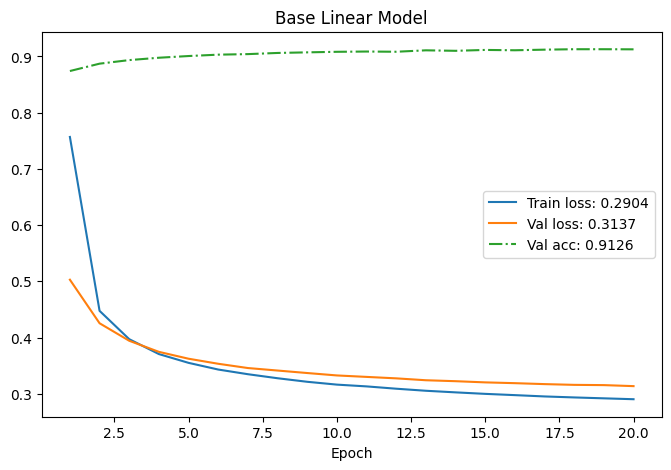

In [66]:
train1, val1, acc1 = base_linear_trainer.train_losses_epoch, base_linear_trainer.val_losses_epoch, base_linear_trainer.val_accuracy_epoch
plotter = Plotter("Base Linear Model")
plotter.plot(train1, val1, acc1)

## ***Non-regularized MLP***
#### This model represents a standard MLP architecture without any regularization techniques applied.

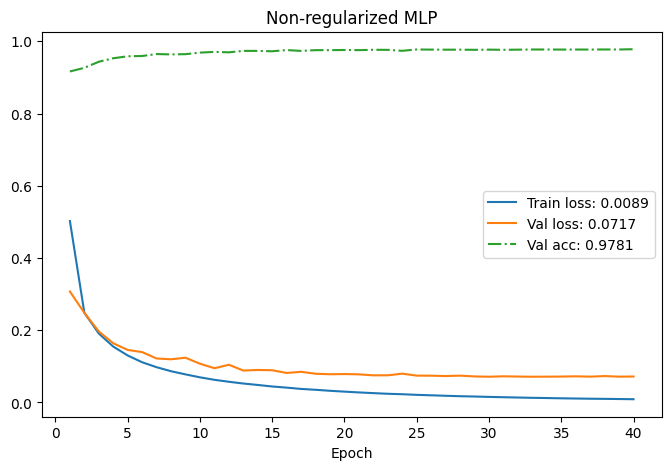

In [76]:
train2, val2, acc2 = trainer_mlp1.train_losses_epoch, trainer_mlp1.val_losses_epoch, trainer_mlp1.val_accuracy_epoch
plotter = Plotter("Non-regularized MLP")
plotter.plot(train2, val2, acc2)

## ***Final Regularized MLP***
#### This is the final version of the regularized MLP, chosen for its superior performance across all tested hypotheses.

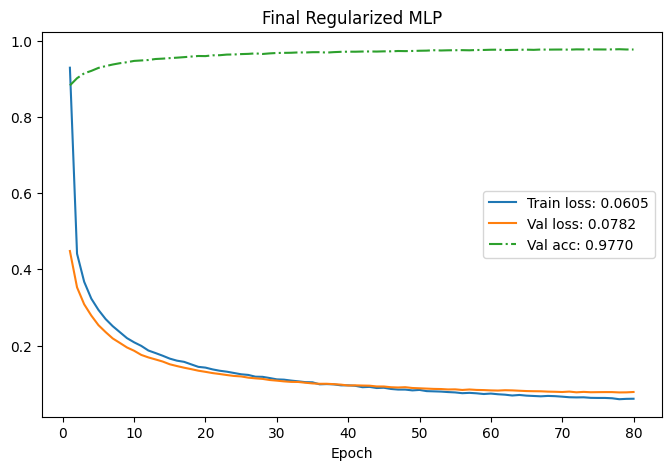

In [77]:
train3, val3, acc3 = trainer_mlp2.train_losses_epoch, trainer_mlp2.val_losses_epoch, trainer_mlp2.val_accuracy_epoch
plotter = Plotter("Final Regularized MLP")
plotter.plot(train3, val3, acc3)

#####
## ***Test Set Evaluation***

In [104]:
def test_evaluation(model, model_name, test_data):
    test_dataloader = test_loader(test_data, 256)
    final_acc = []
    for batch in test_dataloader:
        with torch.no_grad():
            _, acc = model.batch_step(batch)
            final_acc.append(acc.item())
    print(f"{model_name} accuracy: { mean(final_acc):.4f}")

####
#### Despite ***limited capacity*** and ***inability*** to distinguish non-linear patterns, the Baseline Linear Model achieved</br> ***~0.92*** accuracy, proving the simplicity of the ***MNIST*** dataset.
#### Although the non-regularized MLP achieved slightly higher test accuracy, the regularized model demonstrated</br> comparable performance while reducing the risk of overfitting.

In [106]:
test_evaluation(base_linear_model, "Baseline Linear Model", test_tensor)
test_evaluation(mlp_model_1, "Non-regularized MLP", test_tensor)
test_evaluation(mlp_model_2, "Final Regularized MLP", test_tensor)

Baseline Linear Model accuracy: 0.9209
Non-regularized MLP accuracy: 0.9814
Final Regularized MLP accuracy: 0.9793


#####
# ***Conclusion***

- #### Linear models provide a strong baseline, but their narrow capacity significantly limits their ability to distinguish non-linear relationships.
- #### Although introducing hidden layer increases the risk of overfitting, it significantly imporoves performnce by allowing the model</br> to learn non-linear patterns.
- #### Regularization substantially improves model's stability and classification on validation set, however due to increasing training</br> loss effect, it may slightly reduce performance leading to worse accuracy on particular examples.
- #### Activation functions strongly influence optimization speed, with ReLU converging faster than Tanh in this experiment.
- #### Increasing model capacity may negatively impact generalization, as the model begins to fit the training set more closely.
- #### Reducing model capacity tends to improve stability, but may slow convergence and limit overall performance (on given amount of epochs).